## Amazon Fine Food Review - Support Vector Machine - Linear Kernel Algorithm

In [1]:
# Getting all the imports done

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import seaborn as sns

C:\Users\NamrataT\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect(r'C:\Users\NamrataT\Desktop\EXAM\PYTHON\Amazon Fine Food Reviews\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
filtered_data['Score'].value_counts()

1    83876
0    16124
Name: Score, dtype: int64

In [4]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
sorted_data.reset_index(drop=True, inplace=True)

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

In [9]:
final_score = final['Score']
final_score.shape

(87773,)

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below','not','no', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# Combining all the above stundents 
from tqdm import tqdm
from bs4 import BeautifulSoup

preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 87773/87773 [00:56<00:00, 1566.68it/s]


## 1) Applying Support Vector Machine 

## 1.1) Applying Support Vector Machine on BOW, SET 1

In [13]:
# Getting all the imports done

from sklearn.metrics import accuracy_score
#from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
#from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc,roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.linear_model import SGDClassifier
from scipy.sparse import hstack
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

In [14]:
final['Cleaned_Text']=preprocessed_reviews
final_review = final[['Cleaned_Text','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [15]:
# Please write all the code with proper documentation
# TIME BASED SPILTTING
# SIMPLE CROSS VALIDATION

X_1_train, X_test, Y_1_train, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)
#X_1_train, X_1_cv, Y_1_train, Y_1_cv = train_test_split( X_1, Y_1, test_size=0.2,shuffle = False)
print(X_1_train.shape,Y_1_train.shape)

(70218, 1) (70218,)


In [16]:
df_post_split = pd.concat([X_1_train,Y_1_train],axis=1)
x_positive = df_post_split[df_post_split['Score']==1]
x_negetive = df_post_split[df_post_split['Score']==0]

In [17]:
df_post_split['Score'].value_counts()

1    58951
0    11267
Name: Score, dtype: int64

In [18]:
# For every observation of class 1, randomly sample from class 0 without replacement
#x_negetive_upsample = resample(x_negetive, replace = True, n_samples=17000)
x_negative_downsample = resample(x_negetive,replace=True,n_samples=48000,random_state=123) 

In [19]:
print(x_negative_downsample.shape, type(x_positive))

(48000, 2) <class 'pandas.core.frame.DataFrame'>


In [20]:
#df_upsample = pd.concat([x_positive,x_negetive_upsample])
df_upsample = pd.concat([x_positive,x_negative_downsample])
type(df_upsample)
df_upsample.head()

,Cleaned_Text,Score
0,bought apartment infested fruit flies hours tr...,1
1,really good idea final product outstanding use...,1
2,received shipment could hardly wait try produc...,1
3,nothing product bother link top page buy used ...,1
4,love stuff sugar free rot gums tastes good goi...,1


In [21]:
df_upsample['Score'].value_counts()

1    58951
0    48000
Name: Score, dtype: int64

In [22]:
X_Train = df_upsample.drop(['Score'],axis=1)
Y_1_train = df_upsample['Score']
print(X_Train.shape, Y_1_train.shape)

(106951, 1) (106951,)


In [173]:
print(X_Train.shape, Y_1_train.shape)

(70218, 2) (106951,)


In [23]:
# BoW -- transform with unigram and bigram

ngram_vect = CountVectorizer(min_df=10)
D1_Train = ngram_vect.fit_transform(X_Train['Cleaned_Text'])
#D1_Cv = ngram_vect.transform(X_1_cv['Cleaned_Text'])
D1_Test = ngram_vect.transform(X_test['Cleaned_Text'])
print(D1_Train.shape,D1_Test.shape)

(106951, 13385) (17555, 13385)


In [24]:
#n_cv = D1_Cv.get_shape()[0]
n_train = D1_Train.get_shape()[0]
n_test = D1_Test.get_shape()[0]
print(n_train)
print(n_test)

106951
17555


In [25]:
# Standardization Process
# Changes done as suggested

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
scaler.fit(D1_Train)
D1_Train = scaler.transform(D1_Train)
#D1_Cv = scaler.transform(D1_Cv)
D1_Test = scaler.transform(D1_Test)

print(D1_Train.shape)
#print(D1_Cv.shape)
print(D1_Test.shape)

C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\NamrataT\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(106951, 13385)
(17555, 13385)


In [28]:
tuned_param = [{'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}]

In [32]:
#Fitting the SGDClassifier Model to GridSearchCV to find the optimal hyper parameter for L2 Penalty

svm_clf = GridSearchCV(SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced'),tuned_param, cv = 3, scoring = 'roc_auc')
svm_clf.fit(D1_Train,Y_1_train)

print(svm_clf.best_estimator_)
print("AUC Score : ",svm_clf.score(D1_Test,Y_test))

SGDClassifier(alpha=0.1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
AUC Score :  0.9119537996010396


In [57]:
# Fitting the model on test data 

test_neigh = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = 1)
test_neigh.fit(D1_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D1_Test[j:j+1000]))
    #predict_test_prob.extend(test_neigh.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D1_Train[k:k+1000]))
    #predict_train_prob.extend(test_neigh.predict_proba(D1_Train[k:k+1000])[:,1])
    
#print(len(predict_test_prob))
print(len(Y_test))
    
#train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
#test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
Algo Run Successfully on D_Test


In [58]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
44562 3438 4650 54301
[[44562  3438]
 [ 4650 54301]]
Test Confusion Matrix
2418 496 1330 13311
[[ 2418   496]
 [ 1330 13311]]


In [108]:
#

svm_bow_clf = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = 1)
svm_bow_clf.fit(D1_Train,Y_1_train)

calibrated_bow_clf = CalibratedClassifierCV(base_estimator=svm_bow_clf, cv='prefit', method='isotonic')
calibrated_bow_clf.fit(D1_Train,Y_1_train)

print("Best Parameters : ", calibrated_bow_clf.get_params(calibrated_bow_clf))

Best Parameters :  {'base_estimator__alpha': 1, 'base_estimator__average': False, 'base_estimator__class_weight': 'balanced', 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.15, 'base_estimator__learning_rate': 'optimal', 'base_estimator__loss': 'hinge', 'base_estimator__max_iter': None, 'base_estimator__n_iter': None, 'base_estimator__n_iter_no_change': 5, 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__tol': None, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': SGDClassifier(alpha=1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hin

In [109]:
# Predicting the model with Test Data
predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

for j in range(0,n_test,1000):
    predicted_labels_test.extend(calibrated_bow_clf.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(calibrated_bow_clf.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(calibrated_bow_clf.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(calibrated_bow_clf.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


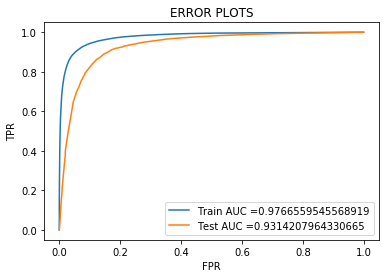

In [110]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [111]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
44489 3511 4485 54466
[[44489  3511]
 [ 4485 54466]]
Test Confusion Matrix
2412 502 1298 13343
[[ 2412   502]
 [ 1298 13343]]


In [112]:
import seaborn as sns

##### Heatmap of Confusion Matrix created on the model created with L2 Regularizer

Text(0.5,1,'Confusion Matrix of Train Data')

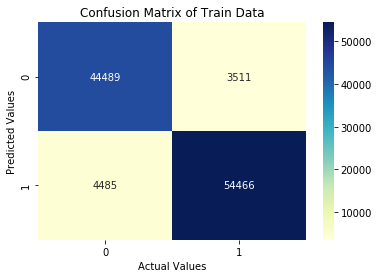

In [113]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

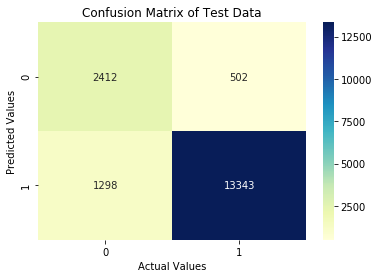

In [114]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

#### Feature Importance with L2 Penalty

In [115]:
feature = ngram_vect.get_feature_names()
coefs_with_fns = sorted(zip(svm_bow_clf.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-0.0641	disappointed   		0.1055	great          
	-0.0465	bad            		0.0692	best           
	-0.0457	worst          		0.0630	delicious      
	-0.0453	disappointing  		0.0626	love           
	-0.0419	thought        		0.0566	loves          
	-0.0419	terrible       		0.0519	good           
	-0.0416	money          		0.0500	perfect        
	-0.0386	horrible       		0.0460	excellent      
	-0.0379	awful          		0.0447	favorite       
	-0.0376	waste          		0.0435	nice           


#### Trying out the SVM Model with L1 penalty

In [116]:
#Fitting the SGDClassifier Model to GridSearchCV to find the optimal hyper parameter for L1 Penalty

svm_clf = GridSearchCV(SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced'),tuned_param, cv = 3, scoring = 'roc_auc')
svm_clf.fit(D1_Train,Y_1_train)

print(svm_clf.best_estimator_)
print("AUC Score : ",svm_clf.score(D1_Test,Y_test))

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
AUC Score :  0.8630333710436142


In [117]:
# Fitting the model on test data 

test_neigh = SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced', alpha = 0.0001)
test_neigh.fit(D1_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D1_Test[j:j+1000]))
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D1_Train[k:k+1000]))
    
print(len(Y_test))

print('Algo Run Successfully on D_Test')
print("="*100)

17555
Algo Run Successfully on D_Test


In [118]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
43678 4322 4985 53966
[[43678  4322]
 [ 4985 53966]]
Test Confusion Matrix
2073 841 1673 12968
[[ 2073   841]
 [ 1673 12968]]


In [119]:
#

svm_bow_clf_l1 = SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced', alpha = 0.0001)
svm_bow_clf_l1.fit(D1_Train,Y_1_train)

calibrated_bow_clf = CalibratedClassifierCV(base_estimator=svm_bow_clf_l1, cv='prefit', method='isotonic')
calibrated_bow_clf.fit(D1_Train,Y_1_train)

print("Best Parameters : ", calibrated_bow_clf.get_params(calibrated_bow_clf))

Best Parameters :  {'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': 'balanced', 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.15, 'base_estimator__learning_rate': 'optimal', 'base_estimator__loss': 'hinge', 'base_estimator__max_iter': None, 'base_estimator__n_iter': None, 'base_estimator__n_iter_no_change': 5, 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l1', 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__tol': None, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal',

In [120]:
# Predicting the model with Test Data
predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

for j in range(0,n_test,1000):
    predicted_labels_test.extend(calibrated_bow_clf.predict(D1_Test[j:j+1000]))
    predict_test_prob.extend(calibrated_bow_clf.predict_proba(D1_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(calibrated_bow_clf.predict(D1_Train[k:k+1000]))
    predict_train_prob.extend(calibrated_bow_clf.predict_proba(D1_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


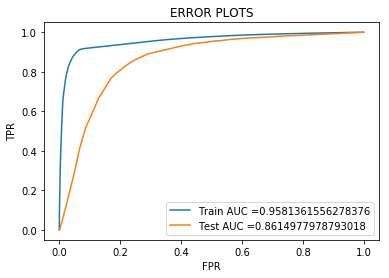

In [121]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [122]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
44774 3226 5179 53772
[[44774  3226]
 [ 5179 53772]]
Test Confusion Matrix
2091 823 1692 12949
[[ 2091   823]
 [ 1692 12949]]


##### Heatmap of Confusion Matrix created on the model created with L1 Regularizer

Text(0.5,1,'Confusion Matrix of Train Data')

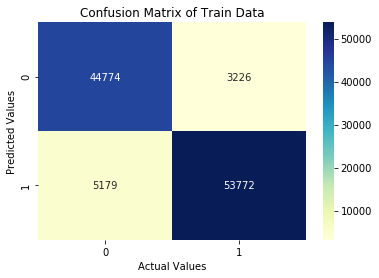

In [123]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

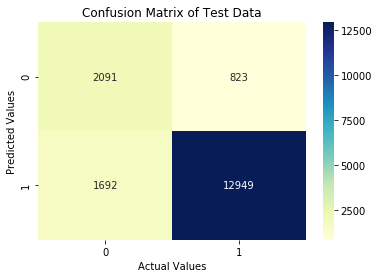

In [124]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

#### Feature Importance on L1 Penalty

In [125]:
feature = ngram_vect.get_feature_names()
coefs_with_fns = sorted(zip(svm_bow_clf_l1.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-1484.3538	mgs            		1664.8365	jolokia        
	-1124.2052	combat         		1320.8658	great          
	-1055.5796	juan           		971.2024	incandescent   
	-1040.2845	contaminates   		942.9329	best           
	-958.6814	syringe        		899.6802	delicious      
	-938.4478	pooped         		899.0502	powerbar       
	-908.3218	troubling      		871.5571	perks          
	-902.4949	worst          		780.9561	cuban          
	-853.0714	needles        		775.9885	fixtures       
	-850.9129	disappointed   		764.6521	galileo        


##### We can see from the above observations that L2 penalty is working better than the other with alpha = 1 as the best hyper-parameter.

## 1.2) Applying SVM - Linear Kernel on TF-IDF, SET 2

In [66]:
from sklearn.model_selection import GridSearchCV

In [24]:
# Creating Tfidf Vectorizer

tfidf_vect = TfidfVectorizer(ngram_range=(1,2) , min_df = 10)
D2_Train = tfidf_vect.fit_transform(X_Train['Cleaned_Text'])
D2_Test = tfidf_vect.transform(X_test['Cleaned_Text'])
print("Some feature names : ", tfidf_vect.get_feature_names()[0:10])
print(D2_Train.shape,D2_Test.shape)

Some feature names :  ['aa', 'aa dark', 'aafco', 'aback', 'abandon', 'abandoned', 'abc', 'abdomen', 'abdominal', 'abdominal pain']
(106951, 76619) (17555, 76619)


In [25]:
scaler_tfidf = StandardScaler(with_mean=False)
scaler_tfidf.fit(D2_Train)
D2_Train = scaler_tfidf.transform(D2_Train)
D2_Test = scaler_tfidf.transform(D2_Test)
print(D2_Train.shape,D2_Test.shape)

(106951, 76619) (17555, 76619)


In [26]:
n_test = D2_Test.get_shape()[0]
n_train = D2_Train.get_shape()[0]
print(n_train,n_test)

106951 17555


In [29]:
#Fitting the SGDClassifier Model to GridSearchCV to find the optimal hyper parameter for L2 Penalty

svm_clf_tfidf = GridSearchCV(SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced'),tuned_param, cv = 3, scoring = 'roc_auc')
svm_clf_tfidf.fit(D2_Train,Y_1_train)

print(svm_clf_tfidf.best_estimator_)
print("AUC Score : ",svm_clf_tfidf.score(D2_Test,Y_test))

SGDClassifier(alpha=1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
AUC Score :  0.9380387022519332


In [30]:
# Fitting the model on test data 

test_neigh = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = 1)
test_neigh.fit(D2_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D2_Test[j:j+1000]))
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D2_Train[k:k+1000]))

print(len(Y_test))

print('Algo Run Successfully on D_Test')
print("="*100)

17555
Algo Run Successfully on D_Test


In [31]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
47718 282 599 58352
[[47718   282]
 [  599 58352]]
Test Confusion Matrix
1934 980 557 14084
[[ 1934   980]
 [  557 14084]]


In [33]:
#

svm_tfidf_clf = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = 1)
svm_tfidf_clf.fit(D2_Train,Y_1_train)

calibrated_tfidf_clf = CalibratedClassifierCV(base_estimator=svm_tfidf_clf, cv='prefit', method='isotonic')
calibrated_tfidf_clf.fit(D2_Train,Y_1_train)

print("Best Parameters : ", calibrated_tfidf_clf.get_params(calibrated_bow_clf))


Best Parameters :  {'base_estimator__alpha': 1, 'base_estimator__average': False, 'base_estimator__class_weight': 'balanced', 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.15, 'base_estimator__learning_rate': 'optimal', 'base_estimator__loss': 'hinge', 'base_estimator__max_iter': None, 'base_estimator__n_iter': None, 'base_estimator__n_iter_no_change': 5, 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__tol': None, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': SGDClassifier(alpha=1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hin

In [34]:
# Predicting the model with Test Data
predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

for j in range(0,n_test,1000):
    predicted_labels_test.extend(calibrated_tfidf_clf.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(calibrated_tfidf_clf.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(calibrated_tfidf_clf.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(calibrated_tfidf_clf.predict_proba(D2_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


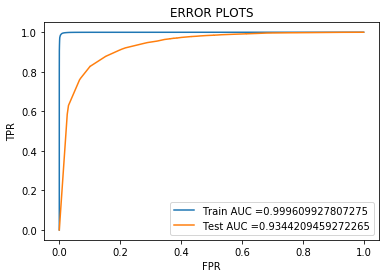

In [35]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [36]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
47544 456 337 58614
[[47544   456]
 [  337 58614]]
Test Confusion Matrix
1658 1256 324 14317
[[ 1658  1256]
 [  324 14317]]


Text(0.5,1,'Confusion Matrix of Train Data')

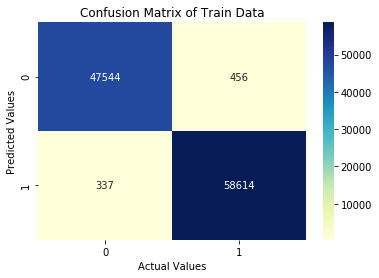

In [37]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

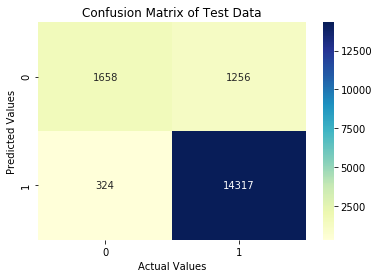

In [38]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

#### Feature Importance for L2 Penalty

In [49]:
feature = tfidf_vect.get_feature_names()
coefs_with_fns = sorted(zip(svm_tfidf_clf.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-0.0261	disappointed   		0.0437	great          
	-0.0217	worst          		0.0322	love           
	-0.0208	terrible       		0.0316	best           
	-0.0188	disappointing  		0.0294	delicious      
	-0.0183	horrible       		0.0276	good           
	-0.0176	awful          		0.0240	perfect        
	-0.0171	threw          		0.0240	loves          
	-0.0166	bad            		0.0209	favorite       
	-0.0165	waste          		0.0207	excellent      
	-0.0161	unfortunately  		0.0206	nice           


#### Trying the SVM Model with L1 Penalty

In [39]:
#Fitting the SGDClassifier Model to GridSearchCV to find the optimal hyper parameter for L2 Penalty

svm_clf_tfidf = GridSearchCV(SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced'),tuned_param, cv = 3, scoring = 'roc_auc')
svm_clf_tfidf.fit(D2_Train,Y_1_train)

print(svm_clf_tfidf.best_estimator_)
print("AUC Score : ",svm_clf_tfidf.score(D2_Test,Y_test))

SGDClassifier(alpha=1e-05, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
AUC Score :  0.8694785663392873


In [40]:
# Fitting the model on test data 

test_neigh = SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced', alpha = .00001)
test_neigh.fit(D2_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D2_Test[j:j+1000]))
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D2_Train[k:k+1000]))

print(len(Y_test))

print('Algo Run Successfully on D_Test')
print("="*100)

17555
Algo Run Successfully on D_Test


In [41]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
47789 211 314 58637
[[47789   211]
 [  314 58637]]
Test Confusion Matrix
1663 1251 971 13670
[[ 1663  1251]
 [  971 13670]]


In [43]:
svm_tftidf_l1 = SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced', alpha = .00001)
svm_tftidf_l1.fit(D2_Train,Y_1_train)

calibrated_tfidf_l1 = CalibratedClassifierCV(base_estimator=svm_tftidf_l1, cv='prefit', method='isotonic')
calibrated_tfidf_l1.fit(D2_Train,Y_1_train)

print("Best Parameters : ", calibrated_bow_clf.get_params(calibrated_tfidf_l1))

Best Parameters :  {'base_estimator__alpha': 1, 'base_estimator__average': False, 'base_estimator__class_weight': 'balanced', 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.15, 'base_estimator__learning_rate': 'optimal', 'base_estimator__loss': 'hinge', 'base_estimator__max_iter': None, 'base_estimator__n_iter': None, 'base_estimator__n_iter_no_change': 5, 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__tol': None, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': SGDClassifier(alpha=1, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hin

In [44]:
# Predicting the model with Test Data
predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

for j in range(0,n_test,1000):
    predicted_labels_test.extend(calibrated_tfidf_l1.predict(D2_Test[j:j+1000]))
    predict_test_prob.extend(calibrated_tfidf_l1.predict_proba(D2_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(calibrated_tfidf_l1.predict(D2_Train[k:k+1000]))
    predict_train_prob.extend(calibrated_tfidf_l1.predict_proba(D2_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


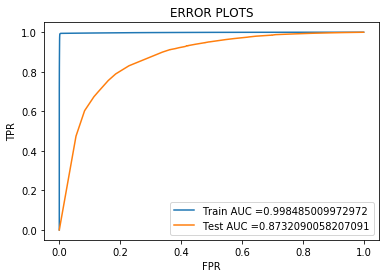

In [45]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [46]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
47806 194 342 58609
[[47806   194]
 [  342 58609]]
Test Confusion Matrix
1696 1218 1017 13624
[[ 1696  1218]
 [ 1017 13624]]


Text(0.5,1,'Confusion Matrix of Train Data')

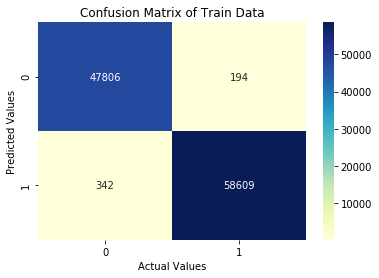

In [47]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

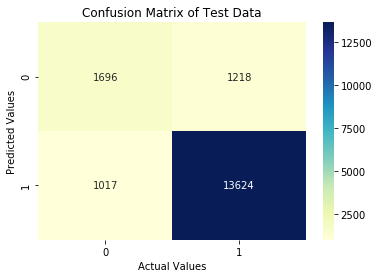

In [48]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

#### Feature Importance with L1 Penalty

In [51]:
feature = tfidf_vect.get_feature_names()
coefs_with_fns = sorted(zip(svm_tftidf_l1.coef_[0], feature))
top = zip(coefs_with_fns[:10], coefs_with_fns[:-11:-1])
for (coef_1, fn_1), (coef_2, fn_2) in top:
    print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))

	-4689.9068	disappointed   		7983.3748	great          
	-3847.5780	awful          		5884.9505	best           
	-3603.4148	terrible       		5556.9382	delicious      
	-3593.3145	disappointing  		5426.8576	love           
	-3562.6120	worst          		5043.3783	perfect        
	-3478.3612	doubt try      		4863.7501	good           
	-3462.3961	disappointed old		4255.6599	loves          
	-3378.8089	double tea     		4095.5152	wonderful      
	-3377.4967	sorry product  		4006.2960	nice           
	-3250.5574	tasteless      		3767.3160	favorite       


##### We can see from the above observations that L2 penalty is working better than the other with alpha = 1 as the best hyper-parameter.

## 1.3) Applying Logistic Regression on Average_Word2Vec, SET 3

##### We performed Feature Engineering on the Average Word2Vec vectorizer by taking the count of the words in the review text as a extra feature. 

In [111]:
final['Cleaned_Text']=preprocessed_reviews
#final['Cleaned_Summary'] = preprocessed_summary
final['Word Count'] = final['Cleaned_Text'].apply(lambda x:len(x.split()))
#final['Summary Word Count'] = final['Cleaned_Summary'].apply(lambda x:len(x.split()))
final.head()
word_count = final['Word Count']

In [112]:
final_review = final[['Cleaned_Text','Word Count','Score']]
X = final_review.drop(['Score'],axis=1)
Y = final_review['Score']

In [113]:
# Time Series Split

X_Train, X_test, Y_1, Y_test = train_test_split(X,Y,test_size=0.2,shuffle = False)

In [114]:
# Creating Word2Vec model on Training Data 

list_of_sentence_w2v = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence_w2v.append(sentence.split())
print(len(list_of_sentence_w2v))

# Creating Word2Vec model with 50 dimension and min_count=5, it will consider the word only if it appeared more than 5 times

w2v_model = Word2Vec(list_of_sentence_w2v, min_count=5, size=50, workers=4)
print(w2v_model.wv.most_similar("good"))
print("="*100)

w2v_words = list(w2v_model.wv.vocab)
print("Total Words Present ", len(w2v_words))
print("Sample Words : ", w2v_words[0:10])
print("="*100)

70218
[('great', 0.8339293599128723), ('decent', 0.8268852233886719), ('fantastic', 0.7957003116607666), ('awesome', 0.7651879787445068), ('terrific', 0.7610093355178833), ('amazing', 0.7494839429855347), ('excellent', 0.684064507484436), ('wise', 0.6662812232971191), ('yummy', 0.6552819013595581), ('delicious', 0.6410372257232666)]
Total Words Present  15758
Sample Words :  ['bought', 'apartment', 'infested', 'fruit', 'flies', 'hours', 'trap', 'attracted', 'many', 'within']


In [102]:
# Fitting Average Word2Vec Model on Train Data

sent_vect_train = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_train.append(sentence_vec)
print(len(sent_vect_train))
print(sent_vect_train[0])

100%|███████████████████████████████████████████████████████████████████████████| 70218/70218 [03:51<00:00, 303.34it/s]


70218
[ 0.78510239  0.46028596  0.18726954 -0.534992    0.1893628  -0.01307698
  0.04118509  0.24834976  0.10994821 -0.25847491  0.20246612 -0.45010346
 -0.24055546 -0.12971463  0.01471933  0.22038952  0.04957401  0.23939787
  0.18839688  0.1602789   0.01023105 -0.09137386 -0.33701633 -0.14720492
  0.68153777 -0.30403854  0.20728829 -0.19143874  0.11481143 -0.48473704
 -0.52161185 -0.39638362  0.50693225  0.18785276  0.70322266  0.26350725
  0.20277223 -0.08745444  0.18638738  0.26163553 -0.08708611  0.26856458
 -0.20571031 -0.10874641  0.49136536  0.10083484 -0.10717678 -0.58421334
 -0.3157855   0.11273041]


In [103]:
# Applying Word2Vec for Vectorization of X_test

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

17555


In [104]:
# Creating Average Word2Vec Vector for Test Data

sent_vect_test = []
for sent in tqdm(list_of_sentence):
    sentence_vec = np.zeros(50)
    count_words = 0
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            count_words += 1
            sentence_vec += vec
    if count_words != 0:
        sentence_vec /= count_words
    sent_vect_test.append(sentence_vec)
print(len(sent_vect_test))
print(sent_vect_test[0])

100%|███████████████████████████████████████████████████████████████████████████| 17555/17555 [01:00<00:00, 290.24it/s]


17555
[ 1.18641997 -0.23663225  0.31533123  0.28622629  0.47371645  0.29983744
 -0.00614696  0.44198672 -0.22873224  0.08356283  0.50203381 -0.11423659
 -1.3503196  -0.13968529 -0.31914102  0.47510421 -0.43859928  0.56917461
 -0.46433411 -0.57597275 -0.72430543 -0.76501292  0.33322503 -0.02734192
 -0.43796567 -0.06572587  0.09075071 -0.08454015 -0.48993591 -0.33239101
  0.11438757 -0.40921643  0.20579889  0.14623299  1.01885849  0.71265842
  0.42409751 -0.04870407  0.10679971 -0.31986162 -0.20165918  0.06908001
 -0.08707324  0.27389266  1.03135626 -0.35555216 -0.92328596 -0.14678274
  0.10584121 -0.45981849]


In [105]:
X_Train_count  =  X_Train['Word Count'].values.reshape(-1,1)
X_Test_count = X_test['Word Count'].values.reshape(-1,1)

In [106]:
#standardising word count feature
import warnings
warnings.filterwarnings('ignore')
word_scalar = StandardScaler()
word_scalar.fit(X_Train_count) 
X_Train_count = word_scalar.transform(X_Train_count)
X_Test_count = word_scalar.transform(X_Test_count)

In [107]:
D3_Train = np.hstack((sent_vect_train,X_Train_count))
D3_Test = np.hstack((sent_vect_test,X_Test_count))

In [108]:
n_train = len(sent_vect_train)
n_test = len(sent_vect_test)
print(n_train)
print(n_test)

70218
17555


In [109]:
# Standardization Process  when we are doing Feature Engineering

from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()
scaler.fit(D3_Train)
D3_Train = scaler.transform(D3_Train)
D3_Test = scaler.transform(D3_Test)

print(D3_Train.shape)
print(D3_Test.shape)

(70218, 51)
(17555, 51)


In [58]:
# Standardization Process when we are not doing Feature Engineering

scaler = StandardScaler()
scaler.fit(sent_vect_train)
D3_Train = scaler.transform(sent_vect_train)
D3_Test = scaler.transform(sent_vect_test)

print(D3_Train.shape)
print(D3_Test.shape)

(106951, 50)
(17555, 50)


In [150]:
#Fitting the SGDClassifier Model to GridSearchCV to find the optimal hyper parameter for L2 Penalty

svm_w2v_clf = GridSearchCV(SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced'),tuned_param, cv = 5, scoring = 'roc_auc')
svm_w2v_clf.fit(D3_Train,Y_1)

print(svm_w2v_clf.best_estimator_)
print("AUC Score : ",svm_w2v_clf.score(D3_Test,Y_test))

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
AUC Score :  0.9026772392961784


In [151]:
# Fitting the model on test data 

test_neigh = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = .0001)
test_neigh.fit(D3_Train,Y_1)

predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D3_Test[j:j+1000]))
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D3_Train[k:k+1000]))

print(len(Y_test))

print('Algo Run Successfully on D_Test')
print("="*100)

17555
Algo Run Successfully on D_Test


In [152]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
9102 2165 9620 49331
[[ 9102  2165]
 [ 9620 49331]]
Test Confusion Matrix
2384 530 2465 12176
[[ 2384   530]
 [ 2465 12176]]


In [153]:
#

svm_w2v_clf = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = 0.0001)
svm_w2v_clf.fit(D3_Train,Y_1)

calibrated_w2v_clf = CalibratedClassifierCV(base_estimator=svm_w2v_clf, cv='prefit', method='isotonic')
calibrated_w2v_clf.fit(D3_Train,Y_1)

print("Best Parameters : ", calibrated_w2v_clf.get_params(calibrated_w2v_clf))

Best Parameters :  {'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': 'balanced', 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.15, 'base_estimator__learning_rate': 'optimal', 'base_estimator__loss': 'hinge', 'base_estimator__max_iter': None, 'base_estimator__n_iter': None, 'base_estimator__n_iter_no_change': 5, 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__tol': None, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal',

In [154]:
# Predicting the model with Test Data
predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

for j in range(0,n_test,1000):
    predicted_labels_test.extend(calibrated_w2v_clf.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(calibrated_w2v_clf.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(calibrated_w2v_clf.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(calibrated_w2v_clf.predict_proba(D3_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


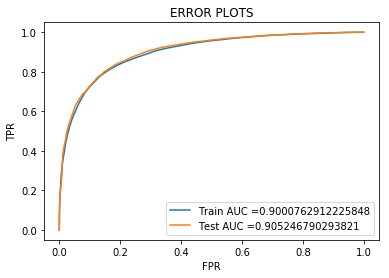

In [155]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [156]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
5707 5560 2587 56364
[[ 5707  5560]
 [ 2587 56364]]
Test Confusion Matrix
1500 1414 623 14018
[[ 1500  1414]
 [  623 14018]]


Text(0.5,1,'Confusion Matrix of Train Data')

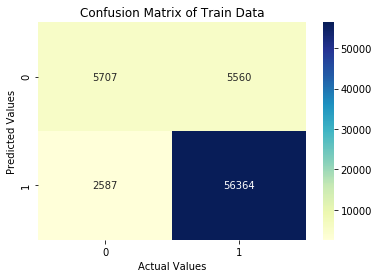

In [157]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

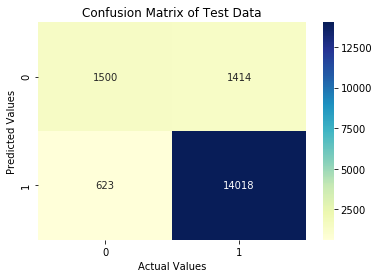

In [158]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

#### Trying the SVM Model with L1 penalty

In [159]:
#Fitting the SGDClassifier Model to GridSearchCV to find the optimal hyper parameter for L1 Penalty

svm_w2v_l1_clf = GridSearchCV(SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced'),tuned_param, cv = 5, scoring = 'roc_auc')
svm_w2v_l1_clf.fit(D3_Train,Y_1)

print(svm_w2v_l1_clf.best_estimator_)
print("AUC Score : ",svm_w2v_l1_clf.score(D3_Test,Y_test))

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
AUC Score :  0.9030656475312111


In [160]:
# Fitting the model on test data 

test_neigh = SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced', alpha = 0.0001)
test_neigh.fit(D3_Train,Y_1)

predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D3_Test[j:j+1000]))
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D3_Train[k:k+1000]))

print(len(Y_test))

print('Algo Run Successfully on D_Test')
print("="*100)

17555
Algo Run Successfully on D_Test


In [161]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
9540 1727 11754 47197
[[ 9540  1727]
 [11754 47197]]
Test Confusion Matrix
2495 419 3016 11625
[[ 2495   419]
 [ 3016 11625]]


In [162]:

svm_w2v_l1_clf = SGDClassifier(loss='hinge', penalty='l1',class_weight = 'balanced', alpha = 0.0001)
svm_w2v_l1_clf.fit(D3_Train,Y_1)

calibrated_w2v_l1_clf = CalibratedClassifierCV(base_estimator=svm_w2v_l1_clf, cv='prefit', method='isotonic')
calibrated_w2v_l1_clf.fit(D3_Train,Y_1)

print("Best Parameters : ", calibrated_w2v_l1_clf.get_params(calibrated_w2v_l1_clf))

Best Parameters :  {'base_estimator__alpha': 0.0001, 'base_estimator__average': False, 'base_estimator__class_weight': 'balanced', 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.15, 'base_estimator__learning_rate': 'optimal', 'base_estimator__loss': 'hinge', 'base_estimator__max_iter': None, 'base_estimator__n_iter': None, 'base_estimator__n_iter_no_change': 5, 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l1', 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__tol': None, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal',

In [163]:
# Predicting the model with Test Data
predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

for j in range(0,n_test,1000):
    predicted_labels_test.extend(calibrated_w2v_l1_clf.predict(D3_Test[j:j+1000]))
    predict_test_prob.extend(calibrated_w2v_l1_clf.predict_proba(D3_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(calibrated_w2v_l1_clf.predict(D3_Train[k:k+1000]))
    predict_train_prob.extend(calibrated_w2v_l1_clf.predict_proba(D3_Train[k:k+1000])[:,1])
    
print(len(predict_test_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

17555
17555
Algo Run Successfully on D_Test


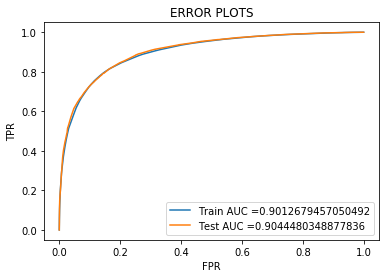

In [164]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

In [165]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
5837 5430 2725 56226
[[ 5837  5430]
 [ 2725 56226]]
Test Confusion Matrix
1556 1358 677 13964
[[ 1556  1358]
 [  677 13964]]


Text(0.5,1,'Confusion Matrix of Train Data')

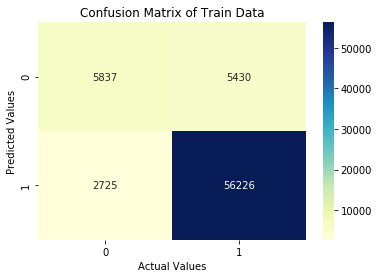

In [166]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

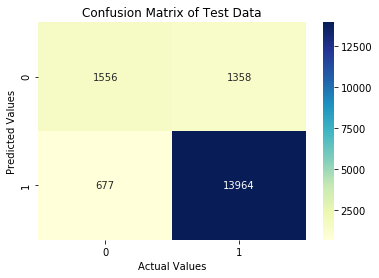

In [167]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

##### We can see from the above observations that L2 penalty is working better than the other with alpha = 0.0001 as the best hyper-parameter.

## 1.4) Applying Logistic Regression on Tf-Idf_Weighted-Average_Word2Vec, SET 4

##### We are using the previously created Tf-Idf and Word2Vec vectorizer .

In [78]:
# Splitting the Training Data into sentences
list_of_sentence = []
for sentence in X_Train['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

106951


In [79]:
# Tf-Idf Weighted Word2Vec for Training Data

tf_idf_features = tfidf_vect.get_feature_names()
dictionary = dict(zip(tfidf_vect.get_feature_names(), list(tfidf_vect.idf_)))

tfidf_w2v_train = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_train.append(sent_vec)
print(len(tfidf_w2v_train))

100%|████████████████████████████████████████████████████████████████████████| 106951/106951 [3:23:28<00:00, 14.05it/s]


106951


In [81]:
# Splitting the Test Data into sentences

list_of_sentence = []
for sentence in X_test['Cleaned_Text']:
    list_of_sentence.append(sentence.split())
print(len(list_of_sentence))

17555


In [82]:
# Tf-Idf Weighted Word2Vec for Test Data

tf_idf_features = tfidf_vect.get_feature_names()

tfidf_w2v_test = []
for sent in tqdm(list_of_sentence):
    sent_vec = np.zeros(50)
    weighted_sum = 0
    for word in sent:
        if word in w2v_words and word in tf_idf_features:
            vec = w2v_model.wv[word]
            tfidf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += vec * tfidf
            weighted_sum += tfidf
    if weighted_sum != 0:
        sent_vec /= weighted_sum
    tfidf_w2v_test.append(sent_vec)
print(len(tfidf_w2v_test))

100%|████████████████████████████████████████████████████████████████████████████| 17555/17555 [40:40<00:00,  7.04it/s]


17555


In [180]:
n_train = len(tfidf_w2v_train)
n_test = len(tfidf_w2v_test)
print(n_train)
print(n_test)

106951
17555


In [84]:
# Standardization Process

scaler = StandardScaler()
scaler.fit(tfidf_w2v_train)
D4_Train = scaler.transform(tfidf_w2v_train)
D4_Test = scaler.transform(tfidf_w2v_test)

print(D4_Train.shape)
print(D4_Test.shape)

(106951, 50)
(17555, 50)


In [193]:
#Fitting the SGDClassifier Model to GridSearchCV to find the optimal hyper parameter for L2 Penalty

svm_clf = GridSearchCV(SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced'),tuned_param, cv = 3, scoring = 'roc_auc')
svm_clf.fit(D4_Train,Y_1_train)

print(svm_clf.best_estimator_)
print("AUC Score : ",svm_clf.score(D4_Test,Y_test))

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
AUC Score :  0.8651610024912412


In [194]:
# Fitting the model on test data 

test_neigh = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = 0.01)
test_neigh.fit(D4_Train,Y_1_train)

predicted_labels_test = []
predicted_labels_train = []

# Predicting the model with Train Data
for j in range(0,n_test,1000):
    predicted_labels_test.extend(test_neigh.predict(D4_Test[j:j+1000]))
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(test_neigh.predict(D4_Train[k:k+1000]))

print(len(Y_test))
    
print('Algo Run Successfully on D_Test')
print("="*100)


17555
Algo Run Successfully on D_Test


In [195]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
37693 10307 13030 45921
[[37693 10307]
 [13030 45921]]
Test Confusion Matrix
2294 620 3253 11388
[[ 2294   620]
 [ 3253 11388]]


In [197]:
#

svm_w2v_tfidf_clf = SGDClassifier(loss='hinge', penalty='l2',class_weight = 'balanced', alpha = 0.01)
svm_w2v_tfidf_clf.fit(D4_Train,Y_1_train)

calibrated_w2v_tfidf_clf = CalibratedClassifierCV(base_estimator=svm_w2v_tfidf_clf, cv='prefit', method='isotonic')
calibrated_w2v_tfidf_clf.fit(D4_Train,Y_1_train)

print("Best Parameters : ", calibrated_w2v_tfidf_clf.get_params(calibrated_w2v_tfidf_clf))

Best Parameters :  {'base_estimator__alpha': 0.01, 'base_estimator__average': False, 'base_estimator__class_weight': 'balanced', 'base_estimator__early_stopping': False, 'base_estimator__epsilon': 0.1, 'base_estimator__eta0': 0.0, 'base_estimator__fit_intercept': True, 'base_estimator__l1_ratio': 0.15, 'base_estimator__learning_rate': 'optimal', 'base_estimator__loss': 'hinge', 'base_estimator__max_iter': None, 'base_estimator__n_iter': None, 'base_estimator__n_iter_no_change': 5, 'base_estimator__n_jobs': None, 'base_estimator__penalty': 'l2', 'base_estimator__power_t': 0.5, 'base_estimator__random_state': None, 'base_estimator__shuffle': True, 'base_estimator__tol': None, 'base_estimator__validation_fraction': 0.1, 'base_estimator__verbose': 0, 'base_estimator__warm_start': False, 'base_estimator': SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', los

In [198]:
# Predicting the model with Test Data
predicted_labels_test = []
predicted_labels_train = []
predict_test_prob = []
predict_train_prob = []

for j in range(0,n_test,1000):
    predicted_labels_test.extend(calibrated_w2v_tfidf_clf.predict(D4_Test[j:j+1000]))
    predict_test_prob.extend(calibrated_w2v_tfidf_clf.predict_proba(D4_Test[j:j+1000])[:,1])
    
for k in range(0,n_train,1000):
    predicted_labels_train.extend(calibrated_w2v_tfidf_clf.predict(D4_Train[k:k+1000]))
    predict_train_prob.extend(calibrated_w2v_tfidf_clf.predict_proba(D4_Train[k:k+1000])[:,1])

print(len(predict_train_prob))
print(len(Y_test))
    
train_fpr, train_tpr, thresholds = roc_curve(Y_1_train, predict_train_prob)
test_fpr, test_tpr, thresholds = roc_curve(Y_test, predict_test_prob)

print('Algo Run Successfully on D_Test')
print("="*100)

106951
17555
Algo Run Successfully on D_Test


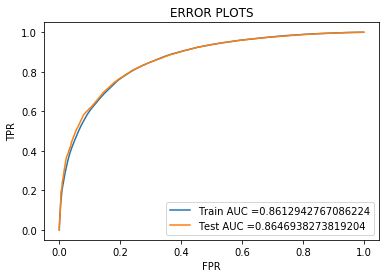

In [199]:
# Plotting the AUC curve on Test and Train Data

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ERROR PLOTS")
plt.show()

print("="*100)

In [200]:
# Getting the confusion metrics

print('Train Confusion Matrix')
tr_true_negetive,tr_false_positive, tr_false_negetive, tr_true_positive = confusion_matrix(Y_1_train,predicted_labels_train).ravel()
print(tr_true_negetive, tr_false_positive, tr_false_negetive, tr_true_positive)
print(confusion_matrix(Y_1_train,predicted_labels_train))
print("="*120)

print('Test Confusion Matrix')
true_negetive,false_positive, false_negetive, true_positive = confusion_matrix(Y_test,predicted_labels_test).ravel()
print(true_negetive, false_positive, false_negetive, true_positive)
print(confusion_matrix(Y_test,predicted_labels_test))
print("="*120)

Train Confusion Matrix
36234 11766 11222 47729
[[36234 11766]
 [11222 47729]]
Test Confusion Matrix
2203 711 2773 11868
[[ 2203   711]
 [ 2773 11868]]


Text(0.5,1,'Confusion Matrix of Train Data')

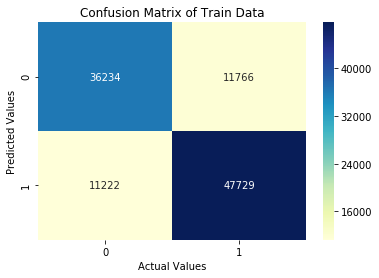

In [201]:
conMatrix= [[tr_true_negetive,tr_false_positive],[tr_false_negetive,tr_true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Train Data')

Text(0.5,1,'Confusion Matrix of Test Data')

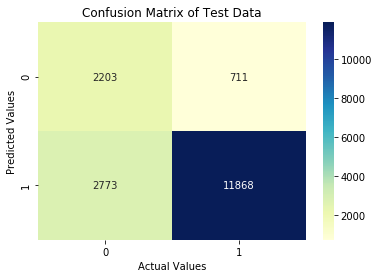

In [202]:
conMatrix= [[true_negetive,false_positive],[false_negetive,true_positive]]
data = conMatrix
sns.heatmap(data, cmap="YlGnBu", annot=True, fmt="d")
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix of Test Data')

### Conclusion 

In [203]:
# Importing Pretty Table
from prettytable import PrettyTable

In [211]:
x = PrettyTable()
x.field_names = ['Vectorizer', 'Hyper-Parameter Alpha','AUC']
x.add_row(['BOW','1','0.93'])
x.add_row(['Tf-Idf','1','0.93'])
x.add_row(['Average Word2Vec','0.0001','0.90'])
x.add_row(['Tf-Idf_Average_Word2Vec','0.01','0.86'])

print(x)

+-------------------------+-----------------------+------+
|        Vectorizer       | Hyper-Parameter Alpha | AUC  |
+-------------------------+-----------------------+------+
|           BOW           |           1           | 0.93 |
|          Tf-Idf         |           1           | 0.93 |
|     Average Word2Vec    |         0.0001        | 0.90 |
| Tf-Idf_Average_Word2Vec |          0.01         | 0.86 |
+-------------------------+-----------------------+------+


#### We have sampled top 100k datapoints that are highly imbalanced. We have thus balanced only the train datapoints with upsampling the negetive points.
#### We have also done feature engineering on the Average Word2Vec vectorizer by adding a new feature that contains the word count of the reviews to see if the model performance is increasing or not.

##### We have also performed a feature importance to check if the model is performing good. We have listed the top 10 features for each class along with their weight vector values.